## Music Genre Classification - with MFCC

TODO - add readme

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy
import pandas as pd

# signal processing
from scipy.io                     import wavfile
from scipy                        import stats, signal
from scipy.fftpack                import fft

from scipy.signal                 import lfilter, hamming
from scipy.fftpack.realtransforms import dct

# lib for music processing
import librosa as lr

# general purpose
import collections

# plotting
from   numpy.lib                  import stride_tricks
import matplotlib        as mpl
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display              import HTML
from base64                       import b64encode

# Classification and evaluation
from sklearn.preprocessing        import StandardScaler
from sklearn                      import svm
from sklearn.cross_validation     import StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.naive_bayes          import GaussianNB
from sklearn.neighbors            import KNeighborsClassifier
from sklearn.ensemble             import RandomForestClassifier
from sklearn.metrics              import classification_report, confusion_matrix

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

/Users/aa/Developer/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import librosa

In [3]:
# figure size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

In [4]:
%load_ext watermark
%watermark -a 'Atul Acharya' -d -m -v -p librosa,sklearn,seaborn,scipy,numpy

Atul Acharya 2016-12-16 

CPython 3.5.2
IPython 5.0.0

librosa 0.4.3
sklearn 0.18.1
seaborn 0.7.1
scipy 0.18.1
numpy 1.11.2

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.54)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [5]:
# GZTAN Dataset 
DATA_DIR = '/Users/aa/Developer/datasets/music_genre/genres'
GENRES_DIR = '/Users/aa/Developer/datasets/music_genre/genres'
GENRES_LIST = ['blues', 'classical', 'country', 'disco', 'hiphop',
                'jazz', 'metal', 'pop', 'rock', 'reggae' ]

import os
import sys
import glob

In [6]:
# Let's see how many files are there
def print_files(genre_list, base_dir=GENRES_DIR, ftype='*.wav'):
    for label, genre in enumerate(genre_list):
        flist =  glob.glob(os.path.join(base_dir, genre, ftype))
        print('dir: {0:10s} ==> #files {1}'.format(genre, len(flist) ))

In [7]:
print_files(GENRES_LIST, GENRES_DIR)

dir: blues      ==> #files 100
dir: classical  ==> #files 100
dir: country    ==> #files 100
dir: disco      ==> #files 100
dir: hiphop     ==> #files 100
dir: jazz       ==> #files 100
dir: metal      ==> #files 100
dir: pop        ==> #files 100
dir: rock       ==> #files 100
dir: reggae     ==> #files 100


In [8]:
### Create a MFCC-CEPS dataset

def write_mfcc(mfcc_ceps, fname):
    ''' Write the MFCC of the given wavefilename
    '''
    base_fn, ext = os.path.splitext(fname)
    data_fn = base_fn + '.mfcc'
    np.save(data_fn, mfcc_ceps)
    
def calc_mfcc_ceps(filename):
    ''' Calc MFCC Ceps of the give wavefilename, using librosa
    '''
    # load the file via librosa
    signal, sample_rate = librosa.load(filename)
    # extract MFCC; get only the 20 features
    mfcc = librosa.feature.mfcc(y=signal, 
                               sr=sample_rate,
                               n_mfcc=20)
    # this will be of shape [13 x Num_of_samples ]
    # we want to transpose it
    mfcc_t = mfcc.T
    write_mfcc(mfcc_t, filename)


In [9]:
sample_file = os.path.join(GENRES_DIR, 'rock', 'rock.00093.au.wav')

print(sample_file)

/Users/aa/Developer/datasets/music_genre/genres/rock/rock.00093.au.wav


In [10]:
calc_mfcc_ceps(sample_file)

In [11]:
b, e = os.path.splitext(sample_file)
m1 = b + '.mfcc.npy'
print(m1)
t1 = np.load(m1)
print(t1.shape)

/Users/aa/Developer/datasets/music_genre/genres/rock/rock.00093.au.mfcc.npy
(1293, 20)


In [12]:
# Create an MFCC CEPS dataset -- IGnore this step if dataset already created!!
from pyprind import ProgBar

def create_ceps_dataset(base_dir):
    ''' Create + save cepstral MFCC for all the WAV files in the base_dir
    '''
    print('Creating MFCC ceps for', base_dir)
    for path, dirs, _ in os.walk(base_dir):
        print(dirs)
        for d in dirs:
            glob_wav = os.path.join(path + '/' + d, "*.wav")
            files = glob.glob(glob_wav)
            print('In {0} are {1} wav files'.format(d, len(files)))
            progbar = ProgBar(len(files))
            for f in files:
                calc_mfcc_ceps(f)
                progbar.update()

In [13]:
create_ceps_dataset(GENRES_DIR)

0%                          100%
[                              ]

Creating MFCC ceps for /Users/aa/Developer/datasets/music_genre/genres
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
In blues are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:07
0%                          100%
[                              ]

In classical are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In country are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In disco are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In hiphop are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In jazz are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In metal are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In pop are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In reggae are 100 wav files


[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:08
0%                          100%
[                              ]

In rock are 100 wav files


[##############################] | ETA: 00:00:00

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]



Total time elapsed: 00:00:08


In [14]:
## Now read the MFCC CEPS files
def read_ceps(genre_list, base_dir=GENRES_DIR):
    '''  Read the MFCC Cepstral coefficients for all files in base_dir, and given list of genres
        
        Returns:
        X:  dataset of cepstral coefficients. Shape [13 x Num_of_samples]
        Y:  label of the directory (one-hot encoded)
    '''
    X = []
    y = []
    for label, genre in enumerate(genre_list):
        for fname in glob.glob(os.path.join(base_dir, genre, "*.mfcc.npy")):
            ceps = np.load(fname)
            if np.any(np.isnan(ceps)):
                print('!!!! NaN values in', fn)
                #print(ceps)
                continue
            else:
                num_ceps = len(ceps)
                # dampen the CEPS -- by taking 10% off from beginning and end of track
                X.append(
                    np.mean(ceps[int(num_ceps / 10):int(num_ceps * 9 / 10)], axis=0))
                y.append(label)
                
    return np.array(X), np.array(y)

In [15]:
X, y = read_ceps(GENRES_LIST)

In [16]:
print(X.shape)
print(y.shape)

(1000, 20)
(1000,)


In [17]:
print(X)

[[ -1.11997148e+02   1.21238132e+02  -1.77501054e+01 ...,  -1.83897536e-01
   -1.66692947e+00   1.81544513e+00]
 [ -1.99126220e+02   1.24311799e+02   7.81554181e+00 ...,   4.59839435e-02
   -2.60645420e-01   3.45716552e-01]
 [ -8.98784562e+01   1.42878391e+02  -2.96622420e+01 ...,  -2.07295617e+00
   -3.28526325e+00  -1.95531306e+00]
 ..., 
 [ -1.45343071e+02   1.03287670e+02  -1.64123941e+01 ...,   3.40847265e-01
    2.60661905e+00   2.54865509e+00]
 [ -1.35048214e+02   9.36368560e+01   8.60264646e+00 ...,   3.04042890e-01
    5.75803510e-01  -1.50165265e-01]
 [ -6.96691994e+01   8.17856429e+01  -4.24591176e+01 ...,   4.19294482e+00
   -1.05298231e+00  -2.99687541e+00]]


### Normalize the MFCCs before Fitting the model



In [18]:
##  Do a Train/Test split
sp = ShuffleSplit(X.shape[0],   # num of tracks
                 n_iter=1,
                 test_size=0.25)  # 25% test
train_split, test_split = zip(*sp)

#### KNN Classifier  test 

In [19]:
knn_clf = KNeighborsClassifier(n_neighbors=1)

X_train, y_train = X[train_split], y[train_split]
X_test, y_test   = X[test_split], y[test_split]

print(X_train.shape)
print(X_test.shape)

(750, 20)
(250, 20)


In [20]:
## Scale the data!! 

from sklearn.preprocessing import StandardScaler

stdscaler = StandardScaler()

stdscaler.fit(X_train)
X_train_std = stdscaler.transform(X_train)
X_test_std  = stdscaler.transform(X_test)

In [21]:
## Train / fit the model
tf = knn_clf.fit(X_train_std, y_train)

In [22]:
train_score = knn_clf.score(X_train_std, y_train)
test_score = knn_clf.score(X_test_std, y_test)

In [23]:
print(train_score)
print(test_score)

0.998666666667
0.568


In [24]:
# get predictions -- to print confusion matrix
y_pred = knn_clf.predict(X_test_std)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[18  0  1  1  0  0  3  0  1  0]
 [ 0 22  0  0  0  1  0  0  0  0]
 [ 1  1 12  2  1  2  0  0  5  2]
 [ 1  1  2 14  3  0  0  2  5  3]
 [ 1  0  0  2 11  2  0  0  4  5]
 [ 0  3  2  0  2 15  0  4  2  1]
 [ 4  0  0  0  1  0 13  0  2  0]
 [ 0  0  1  1  2  0  0 11  1  0]
 [ 2  0  0  3  4  0  1  3 12  0]
 [ 1  1  1  2  7  0  0  3  2 14]]


In [25]:
## Let's Plot Confusion Matrix
## Plot Confusion Matrix
def plot_confusion_matrix(cmatrix, genre_list, name, title):
    plt.figure(num=None, figsize=(10, 10))
    plt.matshow(cmatrix, fignum=False, cmap='Blues', vmin=0, vmax=1.0)
    ax = plt.axes()
    ax.set_xticks(range(len(genre_list)))
    ax.set_xticklabels(genre_list)
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_yticks(range(len(genre_list)))
    ax.set_yticklabels(genre_list)
    
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')
    
    plt.show()


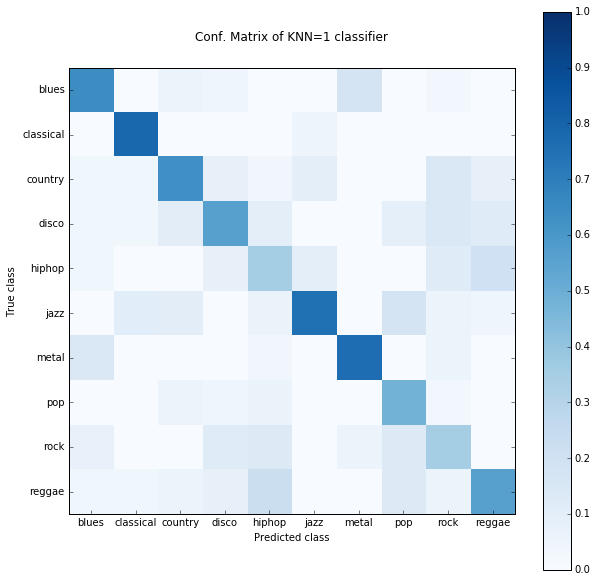

In [26]:
# Normalize the CM
cm_avg = cm   # np.mean(cm, axis=0)
cm_norm = cm_avg / np.sum(cm_avg, axis=0)
plot_confusion_matrix(cm_norm, GENRES_LIST, 'KNN=1', 'Conf. Matrix of KNN=1 classifier')

In [27]:
## Try another scaler:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
X_train_rb = robust.fit_transform(X_train)
X_test_rb  = robust.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=1)

## Train / fit the model
tf = knn_clf.fit(X_train_rb, y_train)

# score
train_score = knn_clf.score(X_train_rb, y_train)
test_score = knn_clf.score(X_test_rb, y_test)

print('Train score', train_score)
print('Test score', test_score)

# get predictions -- to print confusion matrix
y_pred = knn_clf.predict(X_test_rb)
cm = confusion_matrix(y_test, y_pred)
print(cm)

Train score 0.998666666667
Test score 0.552
[[16  0  1  1  0  0  4  1  1  0]
 [ 0 20  0  0  1  2  0  0  0  0]
 [ 1  1 12  0  1  3  0  0  6  2]
 [ 1  1  3 16  2  0  0  1  6  1]
 [ 1  0  2  2 11  2  0  0  4  3]
 [ 0  3  2  1  1 16  0  3  2  1]
 [ 4  0  0  0  1  0 13  0  2  0]
 [ 0  0  1  1  2  0  0 10  2  0]
 [ 2  0  1  3  3  0  1  2 12  1]
 [ 1  1  2  2  7  2  0  2  2 12]]


In [28]:
# Try a cross validation
cvfold = StratifiedKFold(y, n_folds=10)

scores = cross_val_score(knn_clf, 
                         X,
                         y, 
                         scoring='accuracy',
                         cv=cvfold)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.45 (+/- 0.14)


In [29]:
from sklearn.model_selection import StratifiedKFold

In [36]:
## Ensemble learning -- run experiments with different classifiers

# read dataset again
X, y = read_ceps(GENRES_LIST)
print(X.shape)
print(y.shape)

classifiers = {}

classifiers["GNB"]        = GaussianNB()
classifiers["svm_linear"] = svm.SVC(kernel='linear', C=0.3)
classifiers['knn'] = KNeighborsClassifier(n_neighbors=1)
classifiers['RF']  = RandomForestClassifier(n_estimators=10,
                                           criterion='gini',
                                           n_jobs=-1)

results = {}

print('Starting CV...')
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for train_ix, test_ix in skf.split(X, y):
    X_train, y_train = X[train_ix], y[train_ix]
    X_test,  y_test  = X[test_ix],  y[test_ix]
    
    stdscaler = StandardScaler()
    X_train_std = stdscaler.fit_transform(X_train)
    X_test_std  = stdscaler.transform(X_test)
    
    for c_name, clf in classifiers.items():
        print('*** Using clf:', clf)
        if c_name not in results:
            results[c_name] = []
        # train the classifier
        clf.fit(X_train_std, y_train)
        # get score
        score = clf.score(X_test_std, y_test)
        print('Score:', score)
        print('-'*80)
        
        results[c_name].append(score)


(1000, 20)
(1000,)
Starting CV...
*** Using clf: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Score: 0.51
--------------------------------------------------------------------------------
*** Using clf: GaussianNB(priors=None)
Score: 0.43
--------------------------------------------------------------------------------
*** Using clf: SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Score: 0.53
--------------------------------------------------------------------------------
*** Usi

In [37]:
print(results)

{'RF': [0.51000000000000001, 0.55000000000000004, 0.46000000000000002, 0.62, 0.56999999999999995, 0.53000000000000003, 0.48999999999999999, 0.54000000000000004, 0.54000000000000004, 0.54000000000000004], 'GNB': [0.42999999999999999, 0.42999999999999999, 0.40000000000000002, 0.48999999999999999, 0.34999999999999998, 0.42999999999999999, 0.41999999999999998, 0.41999999999999998, 0.48999999999999999, 0.34999999999999998], 'svm_linear': [0.53000000000000003, 0.57999999999999996, 0.5, 0.57999999999999996, 0.59999999999999998, 0.55000000000000004, 0.53000000000000003, 0.57999999999999996, 0.68000000000000005, 0.55000000000000004], 'knn': [0.55000000000000004, 0.60999999999999999, 0.54000000000000004, 0.56000000000000005, 0.63, 0.47999999999999998, 0.56000000000000005, 0.56999999999999995, 0.68999999999999995, 0.52000000000000002]}


In [38]:
results_data = []

for i in range(5):
    rd = []
    for cf in classifiers.keys():
        vals = results[cf]
        rd.append(np.mean(vals) * 100)
    
    results_data.append(rd)

pd.DataFrame(np.asarray(results_data), columns=classifiers.keys())

,RF,GNB,svm_linear,knn
0,53.5,42.1,56.8,57.1
1,53.5,42.1,56.8,57.1
2,53.5,42.1,56.8,57.1
3,53.5,42.1,56.8,57.1
4,53.5,42.1,56.8,57.1


### TODO:  NORMALIZE THE MFCCs!!!